In [1]:
# Import Dependencies

import pandas as pd
from fbprophet import Prophet
import requests
from pprint import pprint
from datetime import datetime, timedelta
from bs4 import BeautifulSoup as bs
from sqlalchemy import create_engine
import psycopg2


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [2]:
# AWS Server Details

server= "bootcampdb.cmwhqarpyd9v.ca-central-1.rds.amazonaws.com"
database = "postgres"
port ="5432"
username = "root"
password = "xy92Hdie"

conn = f"postgres://{username}:{password}@{server}:{port}/{database}"

In [3]:
# Read Bitcoin daily data from Alpha Vantage API

av_api_key = 'IYOYBP274BRSLPM0'

url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CAD&apikey={av_api_key}"

data = requests.get(url).json()
bc_data = data["Time Series (Digital Currency Daily)"]

In [4]:
# Loop through json response API data and transform into lists in python to create pandas dataframe

date = []
open_CAD = []
open_USD = []
high_CAD = []
high_USD = []
low_CAD = []
low_USD = []
close_CAD = []
close_USD = []
volume = []

date = list(bc_data.keys())

for d in date:
  value = bc_data[d]
  close_CAD.append(value['4a. close (CAD)'])
  close_USD.append(value['4b. close (USD)'])
  volume.append(value['5. volume'])
  open_CAD.append(value['1a. open (CAD)'])
  open_USD.append(value['1b. open (USD)'])
  high_CAD.append(value['2a. high (CAD)'])
  high_USD.append(value['2b. high (USD)'])
  low_CAD.append(value['3a. low (CAD)'])
  low_USD.append(value['3b. low (USD)'])

In [5]:
# Create Pandas dataframe

df = pd.DataFrame({"Date": date, "Open_USD": open_USD, "High_USD": high_USD,  "Low_USD": low_USD,  "Close_USD":close_USD})
df.head()




,Date,Open_USD,High_USD,Low_USD,Close_USD
0,2021-03-19,57641.00000000,57689.65000000,56270.74000000,56644.87000000
1,2021-03-18,58912.97000000,60129.97000000,57023.00000000,57648.16000000
2,2021-03-17,56900.74000000,58974.73000000,54123.69000000,58912.97000000
3,2021-03-16,55605.20000000,56938.29000000,53271.34000000,56900.75000000
4,2021-03-15,58976.08000000,60633.43000000,54600.00000000,55605.20000000


In [6]:
engine = create_engine(conn, echo=False)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [ ]:
df.to_sql("coin_price", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "coin_price" ADD PRIMARY KEY ("Date");')

In [ ]:
# Read Bitcoin crypto rating data from Alpha Vantage API


crypto_rating_url = 'https://www.alphavantage.co/query?function=CRYPTO_RATING&symbol=BTC&apikey={av_api_key}'

rating_data = requests.get(crypto_rating_url).json()

rating = rating_data['Crypto Rating (FCAS)']['3. fcas rating']
score = rating_data['Crypto Rating (FCAS)']['4. fcas score']
refresh_date = rating_data['Crypto Rating (FCAS)']['8. last refreshed']


In [ ]:
# Create a pandas df

rating_df = pd.DataFrame({"Date": refresh_date, "Rank": rating, "Score": score}, index=[0])
rating_df['Date'] = pd.to_datetime(rating_df['Date'], infer_datetime_format=True)
rating_df['Date'] = rating_df['Date'].dt.strftime('%Y-%m-%d')

rating_df 

In [ ]:
engine = create_engine(conn, echo=False)

In [ ]:
rating_df.to_sql("rating", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "rating" ADD PRIMARY KEY ("Date");')

In [ ]:
# Coin Market Cap URL of page to be scraped for Market Cap data

cmc_url = 'https://coinmarketcap.com/'

# Retrieve page with the requests module

response = requests.get(cmc_url)

# Create BeautifulSoup object; parse with 'html.parser'

soup = bs(response.text, 'html.parser')

In [ ]:
#Scrape url for the data

results = soup.find_all('div', class_='sc-33i2yg-0 dOnegn')

for r in results:
  header = r.find_all('span', class_="sc-12ja2s9-0 eALoKW")
   
  title =[]
  value =[]
  for values in header:
    data = (values.text.split(":"))
    title.append(data[0])

    if data[0] == "Dominance":
      value.append(data[2][1:5])
    else:
      value.append(data[1][2:])



In [ ]:
# create data table in pandas and clean up data

market_cap_df = pd.DataFrame({"Title": title, "Value": value})
market_cap_df = market_cap_df.drop(index=5)
market_cap_df = market_cap_df.transpose()
columns = market_cap_df.iloc[0].values
market_cap_df.columns = columns
market_cap_df.drop('Title', axis=0, inplace = True)
market_cap_df.reset_index(inplace=True)
market_cap_df = market_cap_df.drop(columns='index')
market_cap_df = market_cap_df.rename(columns={"Dominance": "BTC_Dominance", "Market Cap": "Market_Cap", "24h Vol": "24h_Volume"})
market_cap_df['Market_Cap'] = market_cap_df['Market_Cap'].str.replace("$","")
market_cap_df['24h_Volume'] = market_cap_df['24h_Volume'].str.replace("$","")
market_cap_df = market_cap_df.replace(',','', regex=True)
market_cap_df

In [ ]:
engine = create_engine(conn, echo=False)

In [ ]:
market_cap_df.to_sql("market_cap", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "market_cap" ADD PRIMARY KEY ("Cryptocurrencies");')

In [ ]:
#Use the NY Times API to pull recent Bitcoin news

nyt_api_key = 'AHD58yFBu6t1DV7UGF2hdMCyfo2PvaHq'
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# Store a search term
query = "Bitcoin"

# Search for articles published between a begin date (90 days ago) and end date (current date)

end_date = datetime.today()
begin_date = end_date - timedelta(90)

end_date = end_date.strftime('%Y%m%d')
begin_date = begin_date.strftime('%Y%m%d')


query_url = f"{url}api-key={nyt_api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Retrieve articles
articles = requests.get(query_url).json()

In [ ]:
# Transform API response into pandas df

headline = []
date = []
paragraph = []

articles_list = articles["response"]["docs"]

for article in articles_list:
  headline.append(article["headline"]["main"])
  date.append(article["pub_date"])
  paragraph.append(article["lead_paragraph"])

news_df = pd.DataFrame({"Date": date, "Headline": headline, "Paragraph": paragraph})
news_df['Date'] = pd.to_datetime(news_df['Date'], infer_datetime_format=True)
news_df['Date'] = news_df['Date'].dt.strftime('%Y-%m-%d')
news_df.head(10)



In [ ]:
engine = create_engine(conn, echo=False)

In [ ]:
news_df.to_sql("btc_news", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "btc_news" ADD PRIMARY KEY ("Headline");')

**Facebook Prophet** Machine Learning

In [6]:
# Facebook Prophet Model Setup

fb_df = df[["Date", "Close_USD"]]
fb_df = fb_df.rename(columns={"Date": "ds", "Close_USD": "y"})
fb_df.head()

,ds,y
0,2021-03-19,56644.87000000
1,2021-03-18,57648.16000000
2,2021-03-17,58912.97000000
3,2021-03-16,56900.75000000
4,2021-03-15,55605.20000000


In [7]:
# Create fbProphet model and fit model 
model = Prophet()
model.fit(fb_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
# Model 90 days in the future

future_df = model.make_future_dataframe(periods=90)

In [9]:
#Make predictions

predictions = model.predict(future_df)
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1085,2021-06-13,73297.224055,76082.830546,85093.859013,69113.807880,77476.989984,7247.998151,7247.998151,7247.998151,-34.848525,-34.848525,-34.848525,7282.846676,7282.846676,7282.846676,0.0,0.0,0.0,80545.222206
1086,2021-06-14,73525.740404,76184.959932,85626.716159,69224.313411,77778.304393,7318.966853,7318.966853,7318.966853,7.338598,7.338598,7.338598,7311.628255,7311.628255,7311.628255,0.0,0.0,0.0,80844.707258
1087,2021-06-15,73754.256754,76475.658418,86228.595026,69306.874017,78124.951460,7305.964682,7305.964682,7305.964682,-35.555879,-35.555879,-35.555879,7341.520561,7341.520561,7341.520561,0.0,0.0,0.0,81060.221435
1088,2021-06-16,73982.773103,76673.985501,86294.671282,69423.624660,78411.410500,7426.365288,7426.365288,7426.365288,54.219895,54.219895,54.219895,7372.145393,7372.145393,7372.145393,0.0,0.0,0.0,81409.138391
1089,2021-06-17,74211.289453,76755.214402,86487.982640,69533.444269,78758.957626,7385.690242,7385.690242,7385.690242,-17.371527,-17.371527,-17.371527,7403.061768,7403.061768,7403.061768,0.0,0.0,0.0,81596.979694


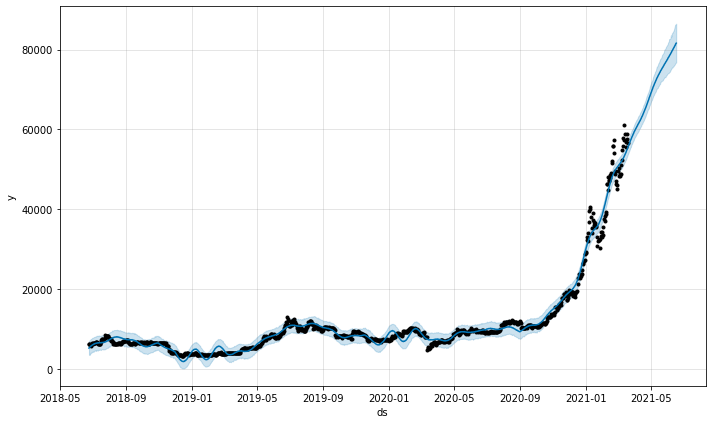

In [15]:
# Plot Predictions
model.plot(predictions).savefig('modelpredictions.png')



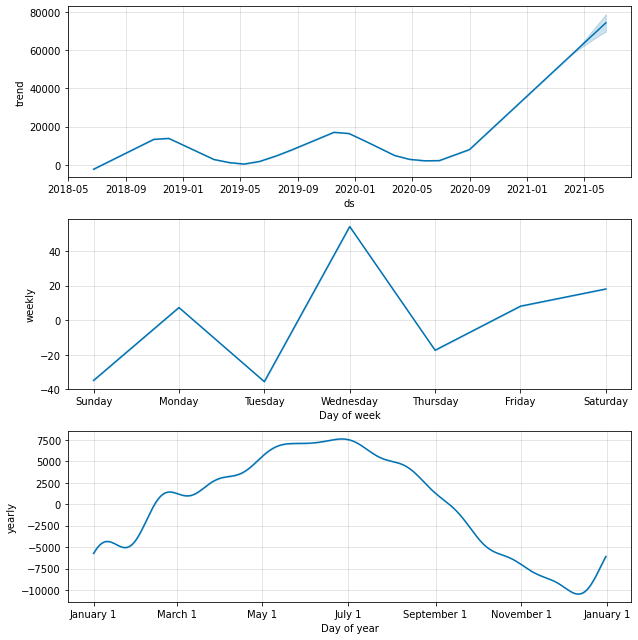

In [16]:
# Plot model components

model.plot_components(predictions).savefig('modelcomponents.png')